### Deep cross network
- https://arxiv.org/abs/1708.05123



In [ ]:
!pip install lightfm
!pip install  recommenders



In [368]:
import warnings
warnings.filterwarnings("ignore")

In [369]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [370]:

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)


In [371]:
SEED = 42
np.random.seed(SEED)

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [372]:
rating_df = pd.read_csv('Ratings.csv')
users_df = pd.read_csv('Users.csv')
book_df = pd.read_csv('Books.csv')

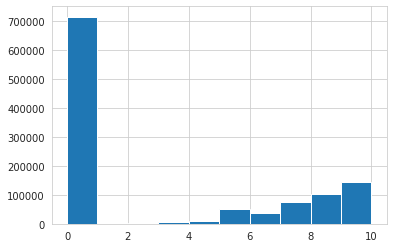

In [373]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df=pd.merge(rating_df,users_df,on="User-ID",how="left")
rating_df['Book-Rating'].hist()

In [374]:
rating_df.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN


In [375]:
rating_df=rating_df[rating_df['Book-Rating']>2]

In [376]:
y = rating_df.groupby('Book-Title').count()['Book-Rating']>=30
books = y[y].index

In [377]:
rating_df = rating_df[rating_df['Book-Title'].isin(books)]
rating_df.shape

(89113, 12)

In [378]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] >= 30
userIndex = x[x].index
rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]

In [379]:
rating_df.rename(columns = {'User-ID':'userID', 'Book-Title':'itemID','Book-Rating':'rating'}, inplace = True)

In [380]:
rating_df.rename(columns = {'Book-Author':'author', 'Year-Of-Publication':'year','Publisher':'publisher','Age':'age'}, inplace = True)

In [381]:
final_ratings=rating_df

In [382]:
rating_df=rating_df[['userID','itemID','rating','author','age','publisher']]

In [383]:
rating_df.head(1)

,userID,itemID,rating,author,age,publisher
20752,4017,The Death of Vishnu: A Novel,10,Manil Suri,48.0,Perennial


### Prepare train test set

In [384]:
authors =list( rating_df['author'])

In [385]:
authors=iter(authors)

In [386]:
dataset = Dataset()

In [387]:
dataset.fit(users=rating_df['userID'], 
            items=rating_df['itemID'],
             item_features=authors)

# quick check to determine the number of unique users and items in the data
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')

Num users: 308, num_items: 1302.


In [388]:
item_features = dataset.build_item_features((x, y) for x,y in zip(rating_df.itemID,authors))


### Light FM

In [389]:
#  TOP K 
K = 10
# model learning rate
LR = 0.25
# no of latent factors
NO_COMPONENTS = 20

#epochs
EPOCHS=30
# no of threads to fit model
THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6


In [390]:
interactions, weights = dataset.build_interactions(rating_df.iloc[:, 0:3].values)

train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=.2,
    random_state=np.random.RandomState(SEED))

In [391]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LR, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

In [392]:
model.fit(interactions=train_interactions,
           item_features=item_features,
           epochs=EPOCHS
           )

### Model evaluation

In [393]:

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [394]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(rating_df, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model, 
                                              num_threads=THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 305.1 seconds for prepare and predict all data.


In [395]:
all_predictions.sample(5, random_state=SEED)


,userID,itemID,prediction
257043,180651,Island of the Blue Dolphins,-8.547554
68413,46909,"Nora, Nora: A Novel",97.904938
30157,23902,The Cradle Will Fall,-32.385571
364076,258534,Void Moon,-22.675274
188480,130571,Rose Madder,-14.254563


### Model Evaluation

In [396]:

from lightfm import cross_validation
# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k 
from lightfm.evaluation import recall_at_k 

In [399]:
print("Train precision: %.2f" % precision_at_k(model, train_interactions, k=15,item_features=item_features).mean())
print("Test precision: %.2f" % precision_at_k(model, test_interactions, k=15,item_features=item_features).mean())

Train precision: 0.20
Test precision: 0.02


In [400]:
print("Train recall: %.2f" % recall_at_k(model, train_interactions, k=15,item_features=item_features).mean())
print("Test recall: %.2f" % recall_at_k(model, test_interactions, k=15,item_features=item_features).mean())

Train recall: 0.08
Test recall: 0.03


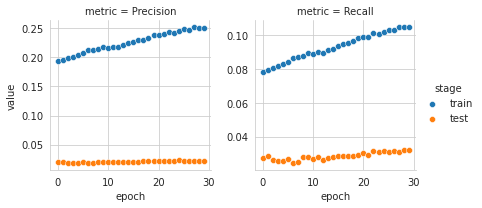

In [403]:
output1, _ = track_model_metrics(model=model, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=15,
                                 item_features=item_features,
                                 no_epochs=EPOCHS, 
                                 no_threads=THREADS)

###  Retrieve the top N similar items

In [407]:
_, item_embeddings = model.get_item_representations(features=item_features)
similar_items(item_id=10, 
              item_features=item_features, 
              model=model)

,itemID,score
0,443,0.693115
1,239,0.685729
2,1227,0.668719
3,1213,0.650342
4,940,0.622153
5,28,0.611824
6,1267,0.594420
7,8,0.575623
8,343,0.564984
9,243,0.559205
